# Introduction
KNN (K nearest neighbour) is a proximity based non-parametric algorithm for classification and regression. Please go through "README" file for details.

In [222]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.neighbors import BallTree
from scipy import stats
from sklearn.datasets import make_blobs
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Helper methods

In [156]:
def plot_KNN(data, n_neighbors, ball_tree):
    '''
    This function finds k-NN and plots the data.
    '''
    X = data[:, :2]
    y = data[:,2] 
    
    
    # grid cell size
    h = .02
    cmap_light = ListedColormap(['#FFAAAA',  '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # we create a mesh grid (x_min,y_min) to (x_max y_max) with 0.02 grid spaces
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # we predict the value (either 0 or 1) of each element in the grid
    Z = predict(data, np.c_[xx.ravel(), yy.ravel()], n_neighbors, ball_tree)
    
    # xx.ravel() will give a flatten array

    # np.c_ : Translates slice objects to concatenation along the second axis.
    # > np.c_[np.array([1,2,3]), np.array([4,5,6])]
    # > array([[1, 4],
    #          [2, 5],
    #          [3, 6]])   (source: np.c_ documentation)
    
    
    
    
    # convert the out back to the xx shape (we need it to plot the decission boundry)
    Z = Z.reshape(xx.shape)
    
    
    # pcolormesh will plot the (xx,yy) grid with colors according to the values of Z
    # it looks like decision boundry
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
   
    # scatter plot of with given points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    
    #defining scale on both axises
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
   
    # set the title
    plt.title('K value = '+str(n_neighbors))

    plt.show()

def train(X):
    """
    As there is no training in KNN, we will create a ball-tree for fast searching of nearest neighbours
    """
    # create BallTree
    ball_tree = BallTree(X[:, :-1])
    return ball_tree

def predict(X, query_point_list, K, ball_tree, problem_type= "classification"):
    """
    Search for K nearest neighbour to the query point
    """
    # get the index of K NN
    _, NN_idx_list = ball_tree.query(query_point_list, K)
    
    # predicted value for query points
    prediction_list = []
    
    # for each query point, get the majority vote of NN (*takes time to execute)
    for NN in tqdm(NN_idx_list):
        
        # get the target of NNs
        NN_target_list = X[NN,-1]
        
        # if problem type is regression, take mean of NNs
        if problem_type == "regression":
            # take the mean
            mean = np.mean(NN_target_list)
            
            # append the mean to prediction list
            prediction_list.append(mean)
        
        # else take majority vote
        else:
            # compute mode
            label = stats.mode(NN_target_list)[0]

            # get mode of NN labels
            prediction_list.append(label)
        
    return np.array(prediction_list)

# Create A Toy Dataset For Classification

In [106]:
# create binary classification data
X, y = make_blobs(n_samples=100, centers=2, n_features=2, 
                  random_state=10, cluster_std= 3)
# add label column
data = np.hstack([X, y.reshape(-1, 1)])

# Visualization And Observation

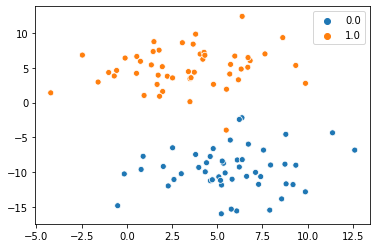

In [116]:
# visualize the dataset
import seaborn as sns
sns.scatterplot(data[:, 0], data[:,1], hue= data[:,-1])

In [108]:
# create a ball tree (can be thought as a part of training)
ball_tree = train(data)

  0%|          | 0/1429956 [00:00<?, ?it/s]

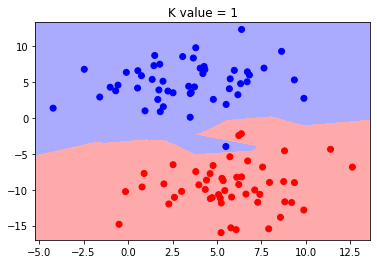

In [110]:
# plot the KNN graph with 1 NN
K = 1
plot_KNN(data, K, ball_tree)

**Low value of K results in overfitting. Note decision bounday is sharp and jagged**

  0%|          | 0/1429956 [00:00<?, ?it/s]

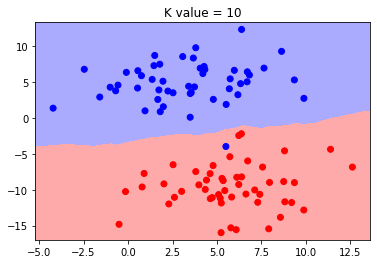

In [111]:
# plot the KNN graph with 10 NN
K = 10
plot_KNN(data, K, ball_tree)

**Medium value of K results in smooth decision surface, as we increase the K, we tends to underfit as our decision surface becomes more and more smooth**

  0%|          | 0/1429956 [00:00<?, ?it/s]

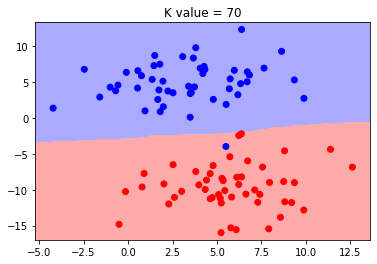

In [114]:
# plot the KNN graph with 70 NN
K = 70
plot_KNN(data, K, ball_tree)

**As K tend to N, we approach uniform distribution (equally likely outcome if data set is balanced, otherwise majority class will dominate)**

# Create A Toy Dataset For Regression

In [118]:
from sklearn.datasets import make_regression

In [213]:
data, y = make_regression(n_samples=200, n_features=1, n_informative=1, noise=20, random_state=10)

# train test split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size= 0.2)

# append target column
X_train = np.hstack([X_train, y_train.reshape(-1, 1)])

# Visualization And Observation

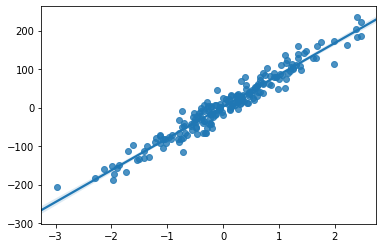

In [214]:
# visualize the dataset
import seaborn as sns
sns.regplot(data, y)

In [220]:
# create a ball tree (can be thought as a part of training)
ball_tree = train(X_train)

In [262]:
# Train and Test MAE when K = 1
K = 1
prediction_list_train = predict(X_train, X_train[:, 0].reshape(-1, 1), K, ball_tree, "regression")
prediction_list_test = predict(X_train, X_test, K, ball_tree, "regression")
train_mae = mean_absolute_error(y_train, prediction_list_train)
test_mae = mean_absolute_error(y_test, prediction_list_test)
print(f"K = {K}\r\nTrain MAE: {train_mae}\r\nTest MAE: {test_mae}")

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

K = 1
Train MAE: 0.0
Test MAE: 21.06015396675385


**As you can see, we are overfitting (train error is 0 and test error is 21.xx) when K is really small.**

In [261]:
# Train and Test MAE when K = 8
K = 8
prediction_list_train = predict(X_train, X_train[:, 0].reshape(-1, 1), K, ball_tree, "regression")
prediction_list_test = predict(X_train, X_test, K, ball_tree, "regression")
train_mae = mean_absolute_error(y_train, prediction_list_train)
test_mae = mean_absolute_error(y_test, prediction_list_test)
print(f"K = {K}\r\nTrain MAE: {train_mae}\r\nTest MAE: {test_mae}")

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

K = 8
Train MAE: 15.679455234935048
Test MAE: 18.109973678573915


**We get good balance if K is reasonable.**

In [260]:
# Train and Test MAE when K = 120
K = 120
prediction_list_train = predict(X_train, X_train[:, 0].reshape(-1, 1), K, ball_tree, "regression")
prediction_list_test = predict(X_train, X_test, K, ball_tree, "regression")
train_mae = mean_absolute_error(y_train, prediction_list_train)
test_mae = mean_absolute_error(y_test, prediction_list_test)
print(f"K = {K}\r\nTrain MAE: {train_mae}\r\nTest MAE: {test_mae}\r\nTrain Target mean (of absolute values):{np.abs(y_train).mean()}")

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

K = 120
Train MAE: 44.377538856980046
Test MAE: 43.65563703046267
Train Target mean (of absolute values):64.7415096666418


**As K approaches N, our model takes more points from the training data as NNs and predictions would be close to "mean" of the training target which is just underfitting.**